In [16]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [17]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [19]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [21]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [23]:
from sqlalchemy import inspect
# details of the Measurement table
columns = inspect(engine).get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [24]:
# details of the Station table
columns = inspect(engine).get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [38]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
trip_starts = '2017-08-01'
trip_ends = '2017-08-07'

import datetime
from dateutil.relativedelta import relativedelta
trip_starts_datatime = datetime.datetime.strptime(trip_starts,"%Y-%m-%d")
trip_ends_datatime = datetime.datetime.strptime(trip_ends,"%Y-%m-%d")

analysis_trip_starts = trip_starts_datatime- relativedelta(years=1)
analysis_trip_ends = trip_ends_datatime- relativedelta(years=1)

analysis_temp = calc_temps(analysis_trip_starts, analysis_trip_ends)
print(analysis_temp)

[(72.0, 78.05263157894737, 83.0)]


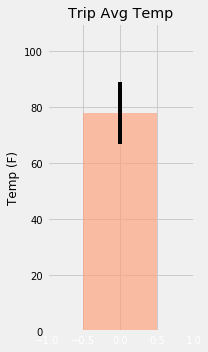

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
import datetime
from dateutil.relativedelta import relativedelta
tmin = analysis_temp[0][0]
tmax = analysis_temp[0][2]
tavg = round(analysis_temp[0][1],2)

yerr = tmax - tmin
plt.figure(figsize = (3,5))
plt.rc('font', size=10) 
plt.bar(0,height=tavg,yerr=yerr, width = 1, color='lightsalmon', alpha = 0.65,  align='center')
plt.xlim(-1,1)
plt.xticks(color="w")
plt.ylim(0,110)
plt.title(f"Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig(f"../Output/Trip Avg Temp ({analysis_trip_starts.date()} - {analysis_trip_ends.date()}).png")  


### Daily Rainfall Average

In [40]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# from datetime import timedelta

measurement_trip = session.query(Measurement.station,func.avg(Measurement.prcp)).\
        filter((func.strftime(Measurement.date) >= analysis_trip_starts)&\
               (func.strftime(Measurement.date) <= analysis_trip_ends)).\
                group_by(Measurement.station).order_by(func.avg(Measurement.prcp).desc()).all()
measurement_trip_df=pd.DataFrame(measurement_trip,columns=['station_ID','total_prcp'])
measurement_trip_df

,station_ID,total_prcp
0,USC00516128,1.220000
1,USC00519281,0.415000
2,USC00514830,0.343333
3,USC00513117,0.206667
4,USC00519523,0.126667
5,USC00519397,0.081667
6,USC00517948,0.045000


In [41]:
station= session.query(Station.station, Station.name,Station.latitude,\
                       Station.longitude,Station.elevation).all()
station_df=pd.DataFrame(station,columns=['station_ID', 'station_name', 'latitude',\
                                         'longitude','elevation'])
station_df

,station_ID,station_name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [42]:
daily_rainfall_average_df = measurement_trip_df.\
   merge(station_df,on='station_ID',how = "inner").\
   sort_values(by='total_prcp', ascending=False)
daily_rainfall_average_df

,station_ID,total_prcp,station_name,latitude,longitude,elevation
0,USC00516128,1.220000,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,0.415000,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00514830,0.343333,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00513117,0.206667,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00519523,0.126667,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00519397,0.081667,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,0.045000,"PEARL CITY, HI US",21.39340,-157.97510,11.9


### Daily Temperature Normals

In [43]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [44]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# start_date = '2017-08-01'
# end_date = '2017-08-07'


# Use the start and end date to create a range of dates
total_days = (analysis_trip_ends  - analysis_trip_starts).days
date_list=[analysis_trip_starts.date()]
for i in range(total_days):
    date_list.append(analysis_trip_starts.date() + datetime.timedelta(days=i+1))
# Strip off the year and save a list of strings in the format %m-%d
date_list_monthday=[]
for x in range(len(date_list)):
    month='{:02d}'.format(date_list[x].month)
    day='{:02d}'.format(date_list[x].day)
    date_list_monthday.append(f'{month}-{day}')
# Use the `daily_normals` function to calculate the normals for each date string
# and append the results to a list called `normals`.
normals = []
for y in date_list_monthday:
    normals.append(daily_normals(y)[0])
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [45]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin','tavg', 'tmax'],index=date_list)
normals_df

,tmin,tavg,tmax
2016-08-01,67.0,75.540000,83.0
2016-08-02,68.0,75.603774,84.0
2016-08-03,70.0,76.611111,85.0
2016-08-04,69.0,76.711538,84.0
2016-08-05,69.0,76.148148,82.0
2016-08-06,67.0,76.250000,83.0
2016-08-07,71.0,77.156863,83.0


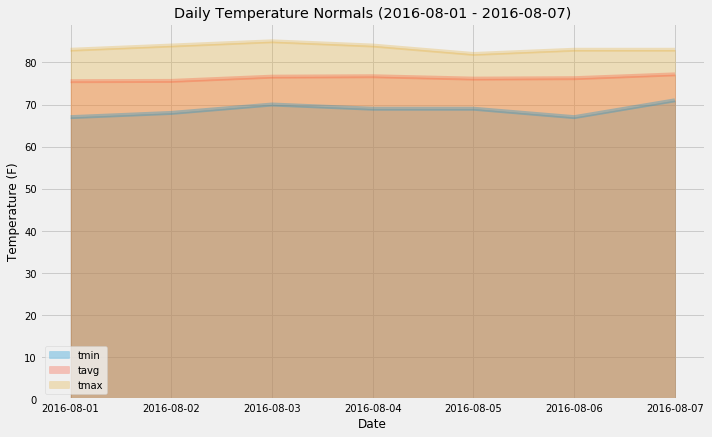

In [46]:
# Plot the daily normals as an area plot with `stacked=False` 
plt.rc('font', size=10) 
normals_df.plot(kind="area", stacked=False, alpha=0.30,rot=0,figsize=(10, 6.18))
plt.title(f"Daily Temperature Normals ({analysis_trip_starts.date()} - {analysis_trip_ends.date()})")
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.savefig(f"../Output/Daily Temperature Normals ({analysis_trip_starts.date()} - {analysis_trip_ends.date()}).png")  

## Close Session

In [47]:
# Close Session
session.close()